## 7.3 Cylindrical Maps
### 7.2.1 2D Datasets

In [3]:
import pandas as pd
import numpy as np
from cartopy import crs as ccrs
import matplotlib.pyplot as plt

In [4]:
# Options to print figures into notebook/increase size
plt.rcParams.update({'font.size': 16, 'figure.figsize': [12, 6]})

In [13]:
fires = pd.read_csv("data/VIIRSNDE_global2018312.v1.0.txt")
fires.head()

,Lon,Lat,Mask,Conf,brt_t13(K),frp(MW),line,sample,Sat,YearDay,Hour
0,27.110006,30.769241,8,52,302.877533,5.814295,242,1735,NDE,2018312,1
1,26.083252,30.534357,9,100,332.959717,24.340988,301,1620,NDE,2018312,1
2,34.865997,28.162659,8,38,301.165985,6.107953,396,2589,NDE,2018312,1
3,34.872623,28.161121,8,71,307.277985,9.287819,396,2590,NDE,2018312,1
4,34.865070,28.158880,8,39,301.227783,6.001442,402,2590,NDE,2018312,1


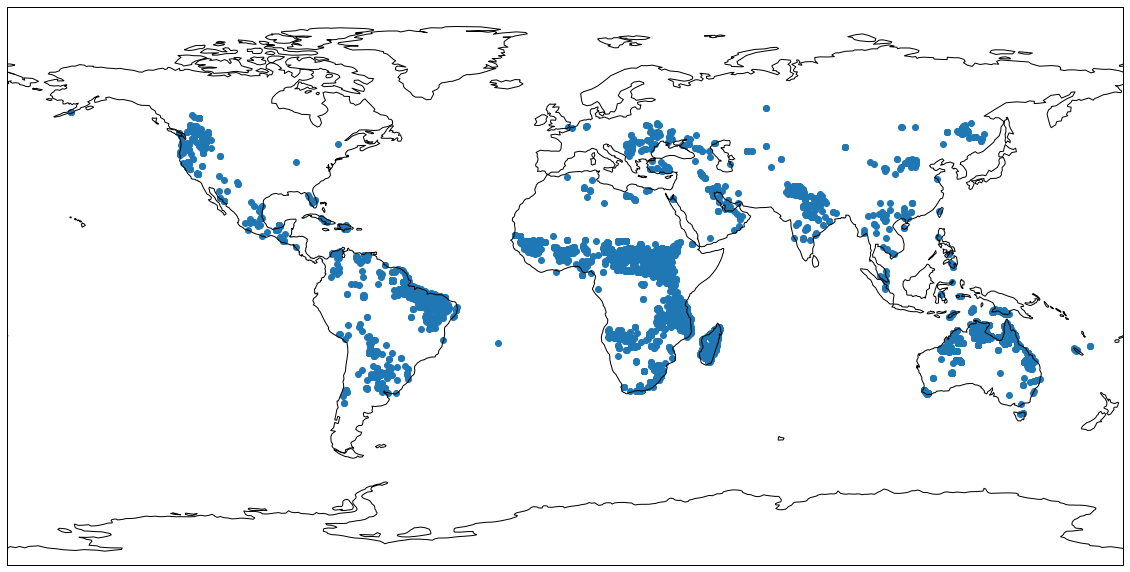

In [4]:
fig = plt.figure(figsize=[20,20])

ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()

plt.scatter(fires['Lon'], fires['Lat'])
plt.show()

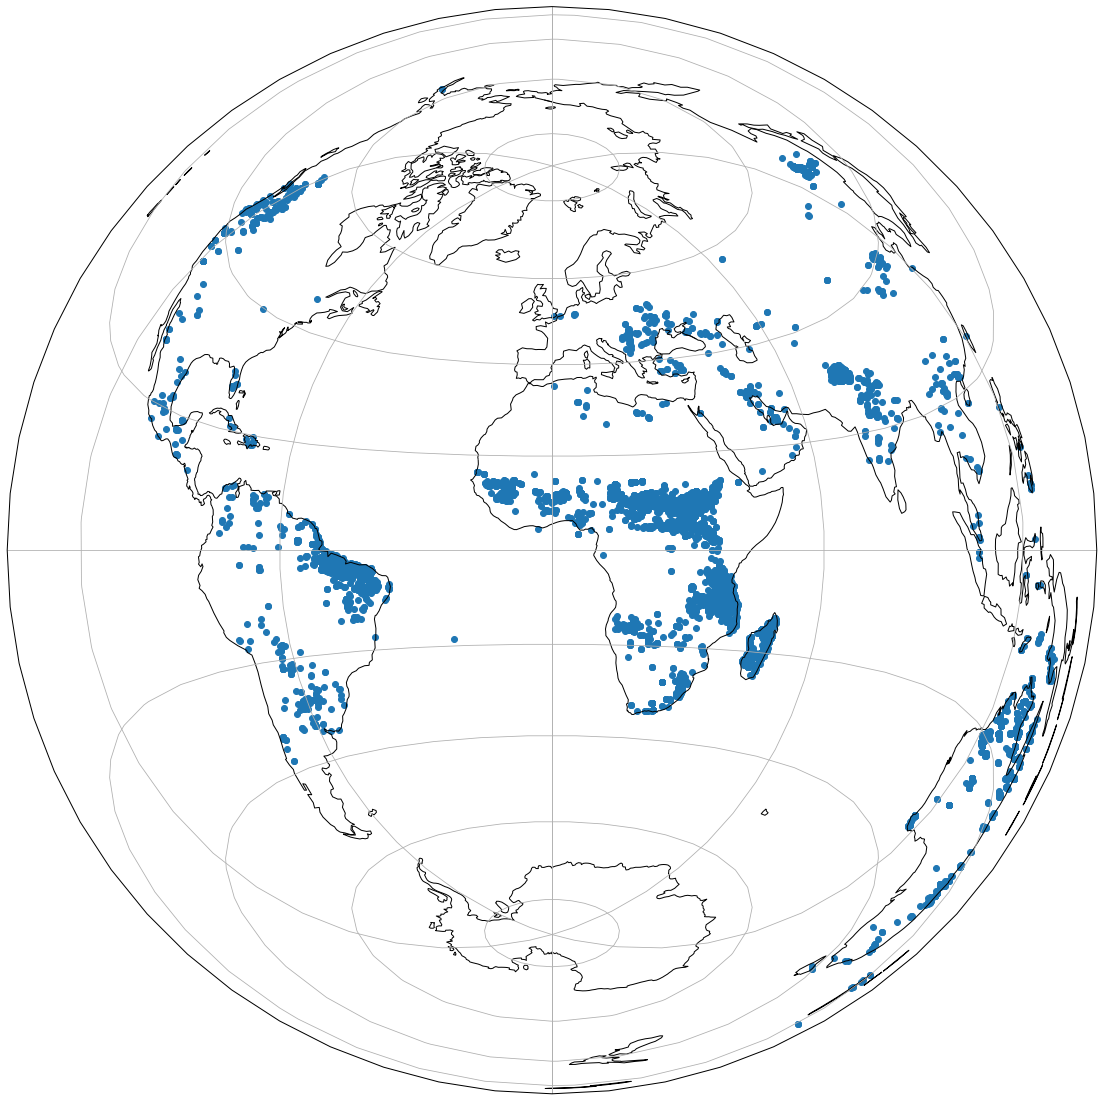

In [5]:
fig = plt.figure(figsize=[20,20])

ax = plt.subplot(projection=ccrs.LambertAzimuthalEqualArea())

ax.coastlines()
ax.gridlines()
ax.set_global()

plt.scatter(fires['Lon'], fires['Lat'], transform=ccrs.PlateCarree())
plt.show()

In [6]:
extent = [-125, -120, 38, 44]

In [7]:
to_proj = ccrs.PlateCarree()
from_proj = ccrs.PlateCarree()

In [8]:
lonLabels = np.arange(-180, 180, 1.5)
latLabels = np.arange(-90, 90, 1)

In [9]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import ticker

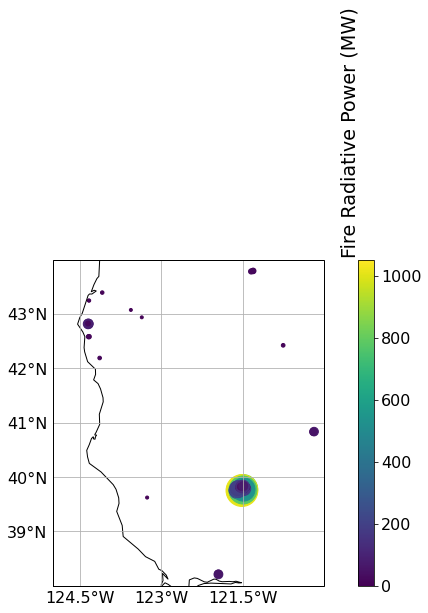

In [10]:
fig = plt.figure()
ax = plt.subplot(projection=to_proj)

ax.coastlines('50m')
ax.set_extent(extent)

frp = ax.scatter(fires['Lon'], fires['Lat'], c=fires['frp(MW)'],
    s=fires['frp(MW)'], transform=from_proj)
cbar = plt.colorbar(frp)
cbar.ax.set_title("Fire Radiative Power (MW)", rotation='vertical', x=-0.5)

# 1) Maps the gridlines to the variable gl
gl = ax.gridlines(crs=to_proj, draw_labels=True)

# 2) Adds two attributes to gl, which are xlocator and ylocator
gl.xlocator = ticker.FixedLocator(lonLabels)
gl.ylocator = ticker.FixedLocator(latLabels)

# 3) Changes labels to show degrees North/South and East/West
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# 4) Removed labels from top and right side
# comment out if you want to include
gl.xlabels_top = False
gl.ylabels_right = False

plt.show()

### 7.3.2 Swath Data

In [6]:
from netCDF4 import Dataset

fname='data/JRR-AOD_v1r1_npp_s201808091955538_e201808091957180_c201808092049460.nc'
file_id = Dataset(fname)
file_id.variables.keys()

dict_keys(['Latitude', 'Longitude', 'StartRow', 'StartColumn', 'AOD550', 'AOD_channel', 'AngsExp1', 'AngsExp2', 'QCPath', 'AerMdl', 'FineMdlIdx', 'CoarseMdlIdx', 'FineModWgt', 'SfcRefl', 'SpaStddev', 'Residual', 'AOD550LndMdl', 'ResLndMdl', 'MeanAOD', 'HighQualityPct', 'RetrievalPct', 'QCRet', 'QCExtn', 'QCTest', 'QCInput', 'QCAll'])

In [4]:
print(file_id.variables['AOD550'].shape, 
      file_id.variables['Latitude'].shape,
      file_id.variables['Longitude'].shape)

(768, 3200) (768, 3200) (768, 3200)


In [5]:
aod = file_id.variables['AOD550'][:,:]
lat = file_id.variables['Latitude'][:,:]
lon = file_id.variables['Longitude'][:,:]

In [6]:
print(file_id.variables['AOD550'].valid_range)

[-0.05  5.  ]


In [7]:
levs = np.arange(0, 1.8, 0.1)
levs

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7])

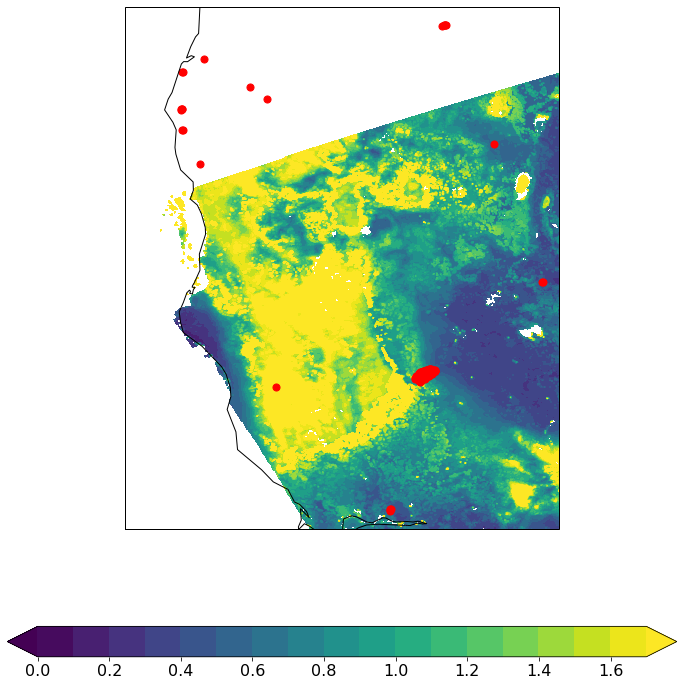

In [15]:
fig = plt.figure(figsize=[12, 12])
ax = plt.subplot(projection=ccrs.PlateCarree())

ax.coastlines('50m')

extent = [-125, -120, 38, 44]
ax.set_extent(extent)

x1 = ax.contourf(lon, lat, aod, levs, extend='both')

fig.colorbar(x1, extend='both',
    orientation="horizontal", fraction=0.05)

# Adds the active fire scatter plot on top
ax.scatter(fires['Lon'], fires['Lat'], color='red', s=50)

plt.show()

### 7.3.3 Quality Flag Filtering

In [17]:
# Import quality flag
quality_flag = file_id.variables['QCAll'][:,:]

# Keep all but the "best" quality using masked arrays
maskHQ = (quality_flag != 0)
aodHQ = np.ma.masked_where(maskHQ, aod)

In [18]:
(aod.count()-aodHQ.count())/aod.count()

0.33269544384282035

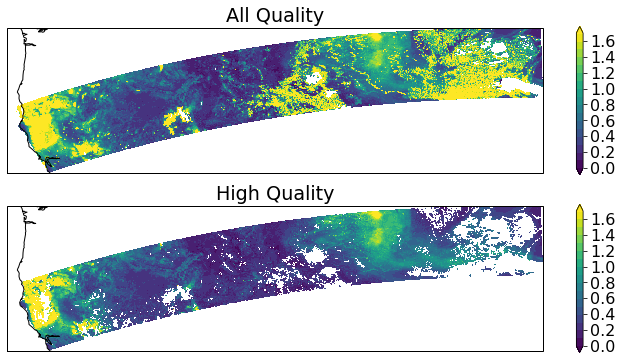

In [21]:
# Top plot
fig = plt.figure()

upper_axis = plt.subplot(2,1,1, projection=ccrs.PlateCarree())
upper_axis.set_title("All Quality")

upper_axis.coastlines('50m')

upper_fig = upper_axis.contourf(lon, lat, aod, levs, extend='both')
fig.colorbar(upper_fig, ax=upper_axis, extend='both')

# Bottom plot
lower_axis = plt.subplot(2,1,2, projection=ccrs.PlateCarree())
lower_axis.set_title("High Quality")

lower_axis.coastlines('50m')

lower_fig = lower_axis.contourf(lon, lat, aodHQ, levs, extend='both')
fig.colorbar(lower_fig, ax=lower_axis, extend='both')

plt.show()

# 7.3 Polar Stereographic Maps

In [23]:
# Cryo-Sat (ESA satellite/data) source: https://n5eil01u.ecs.nsidc.org/ICEBRIDGE/RDEFT4.001/2020.01.01/
import numpy.ma as ma
import xarray as xr

In [24]:
fname = "data/RDEFT4_20200131.nc"
ice = xr.open_dataset(fname)

In [25]:
print(ice['sea_ice_thickness'].min())

<xarray.DataArray 'sea_ice_thickness' ()>
array(-9999., dtype=float32)


In [26]:
ice_masked = ice.where(ice['sea_ice_thickness'] != -9999.)

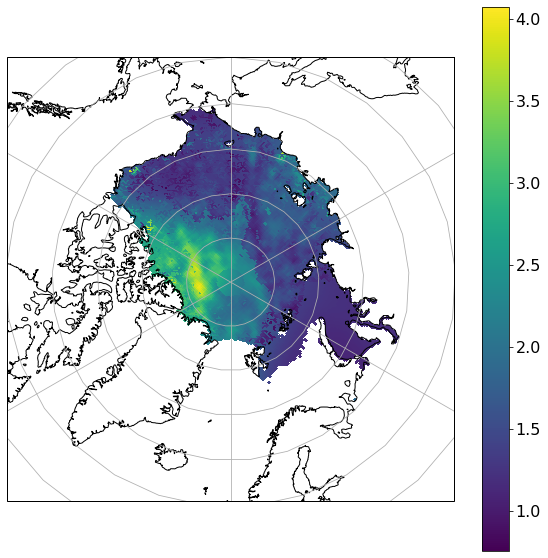

In [30]:
to_proj = ccrs.NorthPolarStereo()
from_proj = ccrs.PlateCarree()

plt.figure(figsize=[10,10])
ax = plt.subplot(projection=to_proj)
ax.coastlines('50m')
ax.gridlines()

ice_plot = ax.pcolormesh(ice['lon'], ice['lat'], ice_masked['sea_ice_thickness'], transform=from_proj)
plt.colorbar(ice_plot)

ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
plt.show()

## 7.4 Geostationary Maps

In [7]:
fname='data/goes-meso/michael/OR_ABI-L1b-RadM1-M3C13_G16_s20182822019282_e20182822019350_c20182822019384.nc'
file_id = Dataset(fname)
list(file_id.variables)

['Rad',
 'DQF',
 't',
 'y',
 'x',
 'time_bounds',
 'goes_imager_projection',
 'y_image',
 'y_image_bounds',
 'x_image',
 'x_image_bounds',
 'nominal_satellite_subpoint_lat',
 'nominal_satellite_subpoint_lon',
 'nominal_satellite_height',
 'geospatial_lat_lon_extent',
 'yaw_flip_flag',
 'band_id',
 'band_wavelength',
 'esun',
 'kappa0',
 'planck_fk1',
 'planck_fk2',
 'planck_bc1',
 'planck_bc2',
 'valid_pixel_count',
 'missing_pixel_count',
 'saturated_pixel_count',
 'undersaturated_pixel_count',
 'min_radiance_value_of_valid_pixels',
 'max_radiance_value_of_valid_pixels',
 'mean_radiance_value_of_valid_pixels',
 'std_dev_radiance_value_of_valid_pixels',
 'percent_uncorrectable_L0_errors',
 'earth_sun_distance_anomaly_in_AU',
 'algorithm_dynamic_input_data_container',
 'processing_parm_version_container',
 'algorithm_product_version_container',
 't_star_look',
 'band_wavelength_star_look',
 'star_id']

In [8]:
file_id.variables['x'][0:10], file_id.variables['y'][0:10]

(masked_array(data=[-0.04424 , -0.044184, -0.044128, -0.044072, -0.044016,
                    -0.04396 , -0.043904, -0.043848, -0.043792, -0.043736],
              mask=False,
        fill_value=1e+20,
             dtype=float32),
 masked_array(data=[0.08848   , 0.088424  , 0.08836801, 0.088312  ,
                    0.088256  , 0.0882    , 0.088144  , 0.08808801,
                    0.088032  , 0.087976  ],
              mask=False,
        fill_value=1e+20,
             dtype=float32))

In [9]:
proj_var = file_id.variables['goes_imager_projection']
print(proj_var)

<class 'netCDF4._netCDF4.Variable'>
int32 goes_imager_projection()
    long_name: GOES-R ABI fixed grid projection
    grid_mapping_name: geostationary
    perspective_point_height: 35786023.0
    semi_major_axis: 6378137.0
    semi_minor_axis: 6356752.31414
    inverse_flattening: 298.2572221
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: -75.0
    sweep_angle_axis: x
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used


In [10]:
# Define the satellite height and central longitude for plots
# Can vary depending on the geo satellite
sat_height = proj_var.perspective_point_height

# Get the radiance data
rad = file_id.variables['Rad'][:,:]

In [11]:
# Define the globe projection
semi_major = proj_var.semi_major_axis
semi_minor = proj_var.semi_minor_axis

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)

In [12]:
central_lon = proj_var.longitude_of_projection_origin

In [13]:
crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height, globe=globe)

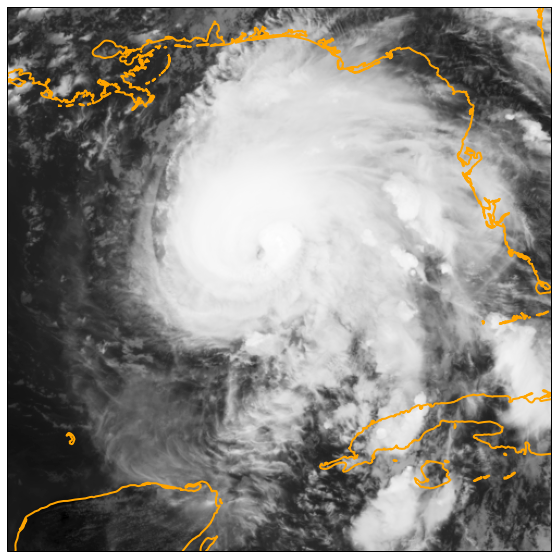

In [36]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(projection=crs)
ax.coastlines('10m', color='orange', linewidth=2)

ax.imshow(rad, origin='upper', cmap='gray_r', extent=imgExtent)

plt.show()

In [37]:
glmfname = 'data/GLM-L2-LCFA_2018_282_20_OR_GLM-L2-LCFA_G16_s20182822000200_e20182822000400_c20182822000427.nc'
file_id_glm = Dataset(glmfname)
file_id_glm.variables.keys()

dict_keys(['event_id', 'event_time_offset', 'event_lat', 'event_lon', 'event_energy', 'event_parent_group_id', 'group_id', 'group_time_offset', 'group_lat', 'group_lon', 'group_area', 'group_energy', 'group_parent_flash_id', 'group_quality_flag', 'flash_id', 'flash_time_offset_of_first_event', 'flash_time_offset_of_last_event', 'flash_lat', 'flash_lon', 'flash_area', 'flash_energy', 'flash_quality_flag', 'product_time', 'product_time_bounds', 'lightning_wavelength', 'lightning_wavelength_bounds', 'group_time_threshold', 'flash_time_threshold', 'lat_field_of_view', 'lat_field_of_view_bounds', 'goes_lat_lon_projection', 'event_count', 'group_count', 'flash_count', 'percent_navigated_L1b_events', 'yaw_flip_flag', 'nominal_satellite_subpoint_lat', 'nominal_satellite_height', 'nominal_satellite_subpoint_lon', 'lon_field_of_view', 'lon_field_of_view_bounds', 'percent_uncorrectable_L0_errors', 'algorithm_dynamic_input_data_container', 'processing_parm_version_container', 'algorithm_product_ve

In [36]:
glmLon = file_id_glm.variables['event_lon'][:]
glmLat = file_id_glm.variables['event_lat'][:]
area = file_id_glm.variables['event_energy'][:]

glmDF = pd.DataFrame({'lat': glmLat, 'lon': glmLon, 'area': area })

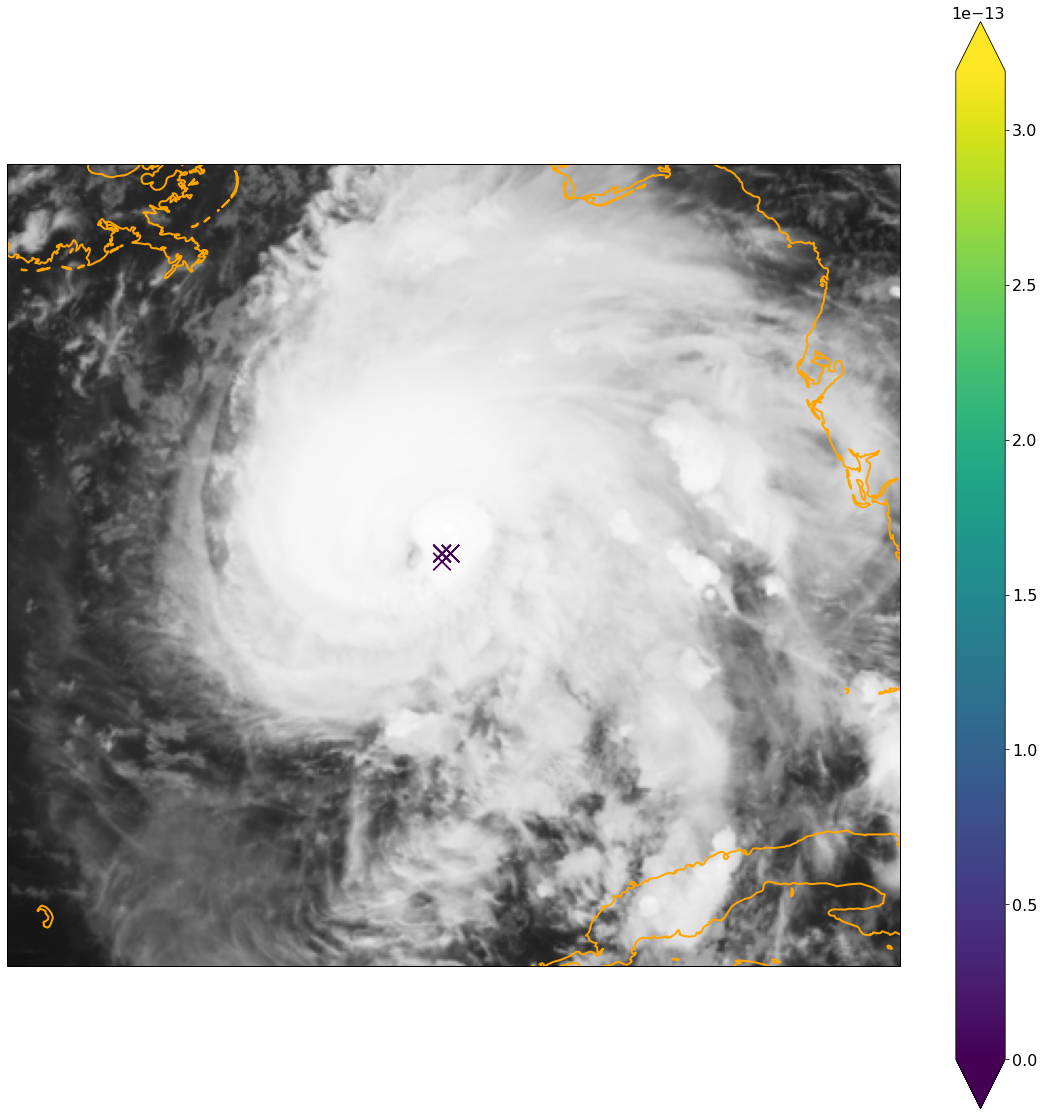

In [37]:
crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height, globe=globe)

from_proj =  ccrs.PlateCarree()
plt.figure(figsize=[10,10])

ax = plt.subplot(projection=crs)
ax.coastlines('10m', color='orange', linewidth=2)
ax.set_extent([-90.0, -82.0, 22.0, 30.0])

# Plot ABI
ax.imshow(rad, origin='upper',cmap='gray_r', extent=imgExtent)

# Add GLM data
plt.scatter(glmDF.lon, glmDF.lat, c=glmDF.area, transform=from_proj,
    s = 300, marker='x')
plt.colorbar(extend='both')

plt.show()

## 7.5 Plotting with OpenDAP

In [38]:
import cartopy.feature as cfeature
import xarray as xr

In [39]:
baseURL = 'http://www.esrl.noaa.gov'
catalogURL = '/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
sstID = xr.open_dataset(baseURL+catalogURL)
print(sstID)

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 1999)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-07-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max: 

In [40]:
sst = sstID.sst
sst

<xarray.DataArray 'sst' (time: 1997, lat: 89, lon: 180)>
[31991940 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-05-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

In [41]:
mostRecent = len(sst.time.values)-1
recentSST = sst.isel(time=mostRecent)

In [42]:
sstmin = 0
sstmax = 30

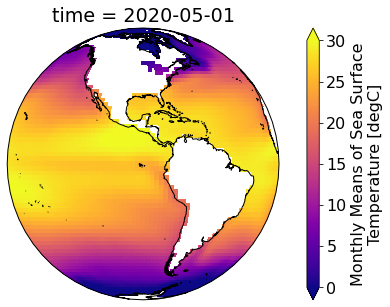

In [43]:
fig = plt.figure(figsize=[10,5])
ax = plt.subplot(projection=ccrs.Orthographic(-90, 0))
recentSST.plot(cmap=plt.get_cmap('plasma'),
    vmin=sstmin, vmax=sstmax, transform=ccrs.PlateCarree())
ax.coastlines('50m')
plt.show()

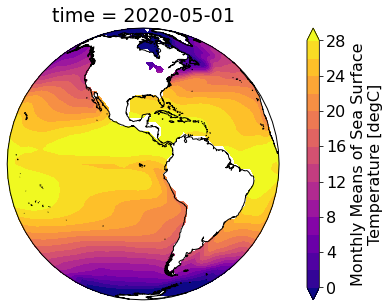

In [44]:
levels = np.arange(sstmin, sstmax, 2)

fig = plt.figure(figsize=[10,5])
ax = plt.subplot(projection=ccrs.Orthographic(-90, 0))
recentSST.plot.contourf(levels=levels, cmap=plt.get_cmap('plasma'), transform=ccrs.PlateCarree())
ax.coastlines('50m')
plt.show()